In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
!wget $data

--2025-10-16 19:19:56--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.007s  

2025-10-16 19:19:56 (10.4 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [2]:
df = pd.read_csv('course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Initial Data Evaluation/Shaping

In [4]:
numeric = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
for c in numeric:
    df[c] = df[c].fillna(0.0)

for c in categorical:
    df[c] = df[c].fillna('NA')

In [7]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [8]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1) 

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Q1: ROC AUC Feature Importance
* Which numerical feature has the highest AUC? **number_of_courses_viewed has the highest AUC**

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
for c in numeric:
    print('%s: %.3f' % (c, roc_auc_score(y_train, df_train[c])))

number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


## Q2: Training the model
* What is the AUC of the model on the validation dataset (to 3 digits)?  **0.817, closest to 0.72**

In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numeric].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numeric].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical + numeric].to_dict(orient='records')
X_test = dv.transform(test_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)



y_pred = model.predict_proba(X_val)[:,1]
#y_pred = model.predict_proba(X_test)[:,1]
print('AUC vs validation set is: %.3f' % (roc_auc_score(y_val, model.predict_proba(X_val)[:,1])))
print('AUC vs test set is: %.3f' % (roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

AUC vs validation set is: 0.817
AUC vs test set is: 0.820


## Q3: Precision and Recall
* At which threshold do precision and recall curves intersect? **Closest is at 0.545**

## Q4: F1 Score
* At which threshold is F1 max'd? **Decreases as threshold increases.  Max is at 0.14**

In [15]:
np.linspace(0,1,101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [27]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

def f1(r,p):
    return 2 * ((p * r)/(p+r))

p = []
r = []

for t in list(np.linspace(0,1,101)):
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p.append(tp / (tp + fp))
    r.append(tp / (fn + tp))
    print('%.2f F1 is: %.2f' % (t,f1(r[-1],p[-1])))

0.00 F1 is: 0.76
0.01 F1 is: 0.76
0.02 F1 is: 0.76
0.03 F1 is: 0.76
0.04 F1 is: 0.76
0.05 F1 is: 0.76
0.06 F1 is: 0.76
0.07 F1 is: 0.76
0.08 F1 is: 0.76
0.09 F1 is: 0.76
0.10 F1 is: 0.76
0.11 F1 is: 0.76
0.12 F1 is: 0.76
0.13 F1 is: 0.76
0.14 F1 is: 0.76
0.15 F1 is: 0.76
0.16 F1 is: 0.76
0.17 F1 is: 0.76
0.18 F1 is: 0.76
0.19 F1 is: 0.76
0.20 F1 is: 0.76
0.21 F1 is: 0.76
0.22 F1 is: 0.76
0.23 F1 is: 0.76
0.24 F1 is: 0.76
0.25 F1 is: 0.76
0.26 F1 is: 0.77
0.27 F1 is: 0.77
0.28 F1 is: 0.77
0.29 F1 is: 0.77
0.30 F1 is: 0.77
0.31 F1 is: 0.77
0.32 F1 is: 0.77
0.33 F1 is: 0.77
0.34 F1 is: 0.77
0.35 F1 is: 0.78
0.36 F1 is: 0.78
0.37 F1 is: 0.78
0.38 F1 is: 0.78
0.39 F1 is: 0.79
0.40 F1 is: 0.79
0.41 F1 is: 0.80
0.42 F1 is: 0.80
0.43 F1 is: 0.81
0.44 F1 is: 0.81
0.45 F1 is: 0.82
0.46 F1 is: 0.82
0.47 F1 is: 0.82
0.48 F1 is: 0.82
0.49 F1 is: 0.82
0.50 F1 is: 0.82
0.51 F1 is: 0.82
0.52 F1 is: 0.82
0.53 F1 is: 0.84
0.54 F1 is: 0.84
0.55 F1 is: 0.84
0.56 F1 is: 0.85
0.57 F1 is: 0.85
0.58 F1 is: 0.

/tmp/ipykernel_3665/2497757257.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p.append(tp / (tp + fp))


In [46]:
pdf = pd.DataFrame(p, index = np.linspace(0,1,101))
rdf = pd.DataFrame(r, index = np.linspace(0,1,101))

In [65]:
pdf['Recall'] = rdf

In [69]:
pdf.loc['0.54':'0.74']

,Precision,Recall
0.54,0.790123,0.901408
0.55,0.797468,0.887324
0.56,0.807692,0.887324
0.57,0.818182,0.887324
0.58,0.827815,0.880282
0.59,0.820690,0.838028
0.60,0.821429,0.809859
0.61,0.824818,0.795775
0.62,0.828358,0.781690
0.63,0.828125,0.746479


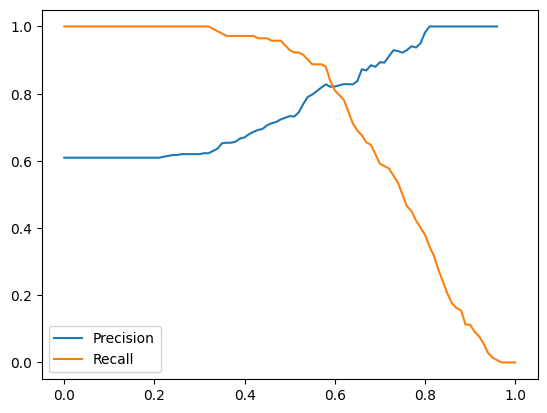

In [31]:
plt.plot(np.linspace(0,1,101),p, label = 'Precision')
plt.plot(np.linspace(0,1,101),r, label = 'Recall')
plt.legend()

## Q5: 5-fold CV
* How large is the standard deviation across folds? **.06 is the closest answer**

In [17]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [18]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numeric].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver = 'liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numeric].to_dict(orient = 'records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    scores.append(roc_auc_score(y_val, y_pred))
    print ('%.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

0.806 +/- 0.000
0.839 +/- 0.033
0.818 +/- 0.040
0.814 +/- 0.035
0.822 +/- 0.036


In [19]:
np.std([.806, .839, .818, .814, .822])

np.float64(0.01096175168483576)

In [20]:
np.std(scores)

np.float64(0.03580711942905165)

In [21]:
abs(.006 - .036)

0.03

In [22]:
abs(.06-.036)

0.024

## Q6: Hyperparameter Tuning
* Which value of c leads to the best mean score? **c = .000001 is the best**

In [25]:
for c in [0.000001, 0.001, 1]:
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    print ('C: %f --> %.3f +/- %.3f' % (c,np.mean(scores), np.std(scores)))

C: 0.000001 --> 0.560 +/- 0.024
C: 0.001000 --> 0.867 +/- 0.029
C: 1.000000 --> 0.822 +/- 0.036
